# Обнаружение и локализация отказов инерциальной навигационной системы ODIN UAV
Имеется 4 папки с данными при разлиичных продольных скоростях движения объекта. В каждой папке по 280 измерений показаний ИНС (каждая серия длится 50 секунд с интервалом 0.1).

In [189]:
import pandas as pd
import glob
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


np.random.seed(0)

In [190]:
file = 'dataset/velocity2/experiment121.csv'
df = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
df.head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_u2,fault_y1,fault_y2,comp_fault
0,-0.240246,-0.228259,-0.087066,-0.321061,-0.009765,-0.344491,0.0,0.0,0.0,0.0,0.0
1,-0.240246,-0.228259,0.015985,-0.164281,-0.009262,-0.161122,0.0,0.0,0.0,0.0,0.0
2,-0.240246,-0.228259,-0.036406,-0.143049,-0.004363,-0.070550,0.0,0.0,0.0,0.0,0.0
3,-0.240246,-0.228259,0.024768,-0.064049,-0.001919,-0.030836,0.0,0.0,0.0,0.0,0.0
4,-0.240246,-0.228259,-0.082591,-0.065805,-0.000846,-0.013743,0.0,0.0,0.0,0.0,0.0


Данные представляют собой временные ряды:

- u1, u2 - сигналы управления аппаратом
- y1, y2 - измерения гироскопа и акселерометра
- y_nominal1,	y_nominal2 - ожидаемые показания гироскопа и акселерометра
- fault_u1, fault_u2 - отказы систем управления (не присутствуют в датасете и не рассматриваются)
- fault_y1, fault_y2 - отказы гироскопа и акселерометра (0 - отсутствие отказаб другие значения - различные формы отказов)
- comp_fault - отказ компонента UAV (не присутствуют в датасете и не рассматриваются)

Требуется определить наличие отказа инерциальной навигационной системы (гироскопа или акселерометра). **Target**: fault_y1, fault_y2

Требуется решить задачу классификации временных рядов. В качестве метрики выберем f1-score, для наглядности также булем рассматривать confusion matrix

Будем рассматривать окно длиной 20 измерений (1 секунда). Будем считать, что отказ произошел, если целевая переменная имеет ненулевое значение на всем окне. 

In [247]:
files = glob.glob('dataset/*/*.csv')

measurement_step = 10

data = []
for file in files:
  if(file != 'data_model.csv'):
      temp = pd.read_csv(file, usecols = ['u1', 'u2', 'y1', 'y2', 'y_nominal1', 'y_nominal2',
                                          'fault_u1', 'fault_u2', 'fault_y1', 'fault_y2', 'comp_fault'])
      indexes = range(0, temp.shape[0], measurement_step)
      temp = temp.iloc[indexes][:]
      temp.reset_index(inplace=True)
      data.append(temp)      
len(data)

1120

Уберем строки, не относящиеся к отказу ИНС и заменим ненулевые значения отказов на 1.

In [248]:
drop_cols = ['fault_u1', 'fault_u2', 'comp_fault', 'index']

for experiment in data:
    experiment.drop(drop_cols, inplace=True, axis=1)
    experiment['fault_y1'].replace([1., 2., 3,], 1, inplace=True)
    experiment['fault_y2'].replace([1., 2., 3,], 1, inplace=True)
data[23].head()

,u1,u2,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2
0,0.295509,-0.106547,0.011852,-0.003908,0.006568,-0.066288,0.0,0.0
1,0.295509,-0.106547,-0.018340,0.025243,0.000022,-0.000476,0.0,0.0
2,0.295509,-0.106547,0.012469,0.055155,0.000021,-0.000435,0.0,0.0
3,0.295509,-0.106547,-0.039980,-0.003755,0.000021,-0.000435,0.0,0.0
4,0.295509,-0.106547,-0.049325,-0.037429,0.000021,-0.000435,0.0,0.0


In [249]:
data[133].shape

(50, 8)

Сформируем датасет следующим образом: 
- скользящее окно длиной 20 по каждому из экспериментов
- отказ датчика произошел, если на протяжении >10 сигнал отказа имеет значение 1

In [250]:
new_cols = []
for col in data[0].drop(['fault_y1', 'fault_y2'], axis=1).columns:
    new_cols += [col + '_' + str(i) for i in range(20)]
new_cols += ['fault_y1', 'fault_y2']

In [251]:
df = pd.DataFrame(data=None, columns=new_cols)
df

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,y_nominal2_12,y_nominal2_13,y_nominal2_14,y_nominal2_15,y_nominal2_16,y_nominal2_17,y_nominal2_18,y_nominal2_19,fault_y1,fault_y2


In [252]:
lag = 19
for k, experiment in enumerate(data):
    for i in range(lag, experiment.shape[0]):
        sample = []
        u1_data = list(experiment.loc[(i-lag):i]['u1'])
        u2_data = list(experiment.loc[(i-lag):i]['u2'])
        y1_data = list(experiment.loc[(i-lag):i]['y1'])
        y2_data = list(experiment.loc[(i-lag):i]['y1'])
        y_nominal1_data = list(experiment.loc[(i-lag):i]['y_nominal1'])
        y_nominal2_data = list(experiment.loc[(i-lag):i]['y_nominal2'])
        
        sample_fault_y1 = list(experiment.loc[(i-lag):i]['fault_y1'])
        if sum(sample_fault_y1) > 10:
            fault_y1_data = [1]
        else:
            fault_y1_data = [0]
            
        sample_fault_y2 = list(experiment.loc[(i-lag):i]['fault_y2'])
        if sum(sample_fault_y2) > 10:
            fault_y2_data = [1]
        else:
            fault_y2_data = [0]
        sample = u1_data + u2_data + y1_data + y2_data + y_nominal1_data + y_nominal2_data + fault_y1_data + fault_y2_data
        df.loc[len(df)] = sample
    if k % 100 == 0:
        print(k, ' of ', len(data))

0  of  1120
100  of  1120
200  of  1120
300  of  1120
400  of  1120
500  of  1120
600  of  1120
700  of  1120
800  of  1120
900  of  1120
1000  of  1120
1100  of  1120


In [253]:
df.shape

(34720, 122)

In [254]:
df.to_csv('dataset_preprocessed.csv')

## EDA

Рассмотрим сбалансированность датасета

In [255]:
df = pd.read_csv('dataset_preprocessed.csv', index_col=0)
df.head(10)

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,y_nominal2_12,y_nominal2_13,y_nominal2_14,y_nominal2_15,y_nominal2_16,y_nominal2_17,y_nominal2_18,y_nominal2_19,fault_y1,fault_y2
0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
5,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
6,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
7,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
8,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0
9,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0


In [256]:
n_faults_y1 = df['fault_y1'].value_counts()[1]
n_faults_y2 = df['fault_y2'].value_counts()[1]
n_no_faults = df.shape[0] - n_faults_y1 - n_faults_y2

In [257]:
data = dict(
    categories = ['Total', 'No fault', 'Fault','Fault y1', 'Fault y2'],
    parent = ['', 'Total', 'Total', 'Fault', 'Fault'],
    value = [df.shape[0], n_no_faults, n_faults_y1+n_faults_y2, n_faults_y1, n_faults_y2]
)

fig = px.sunburst(data, names='categories', parents='parent', values='value', branchvalues='total')
fig.show()

Датасет несбалансирован по классу отсутсвия отказов. Потребуется стратифицированная выборка

Рассмотрим влияние разных сигналов на наличие отказа. Для удобства создадим столбец с кодированием LE 

In [258]:
df['fault_LE'] = 0
df['fault_LE'].loc[ (df['fault_y1'] == 0) & (df['fault_y1'] == 0)] = 0
df['fault_LE'].loc[df['fault_y1'] == 1] = 1
df['fault_LE'].loc[df['fault_y2'] == 1] = 2
df['fault_LE'].value_counts()

0    18758
2     8037
1     7925
Name: fault_LE, dtype: int64

In [259]:
df.head()

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,y_nominal2_13,y_nominal2_14,y_nominal2_15,y_nominal2_16,y_nominal2_17,y_nominal2_18,y_nominal2_19,fault_y1,fault_y2,fault_LE
0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0
4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,-0.00018,0.0,0.0,0


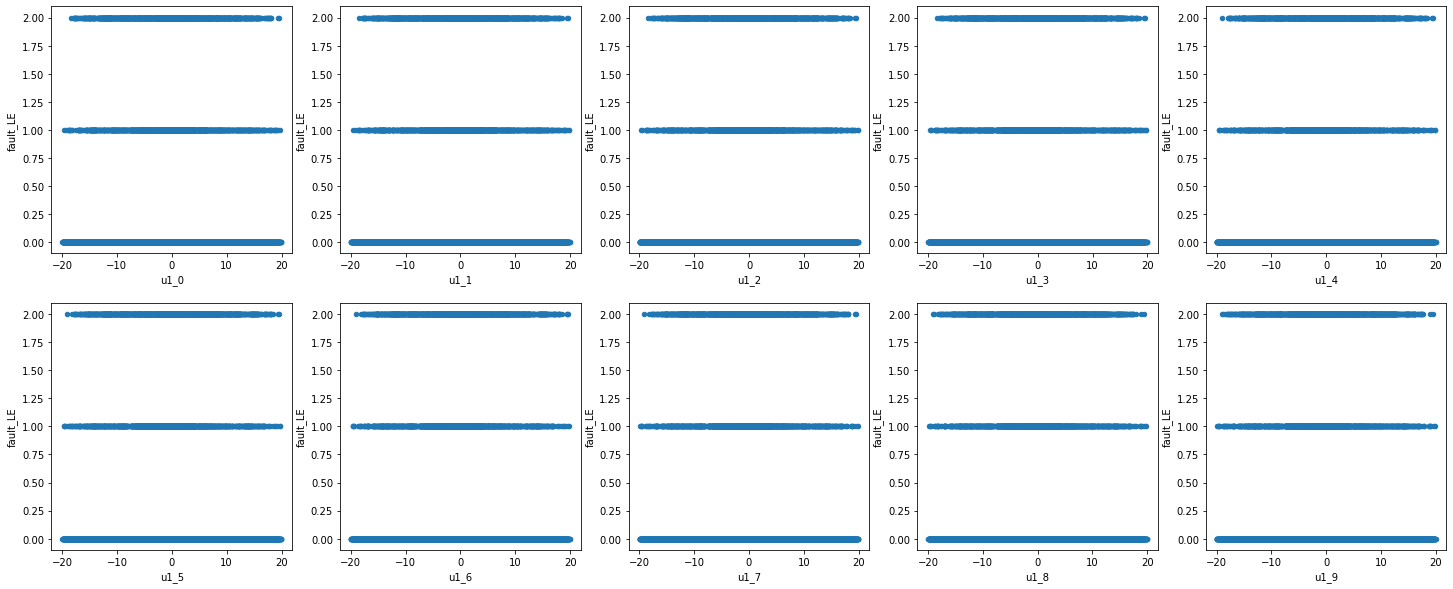

In [204]:
def plot_on_key(df, key):
    cols = [col for col in df.columns if key in col and 'fault' not in col][:10]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    for idx, feature in enumerate(cols):
        df.plot(feature, "fault_LE", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])
    plt.show()
plot_on_key(df, 'u1')

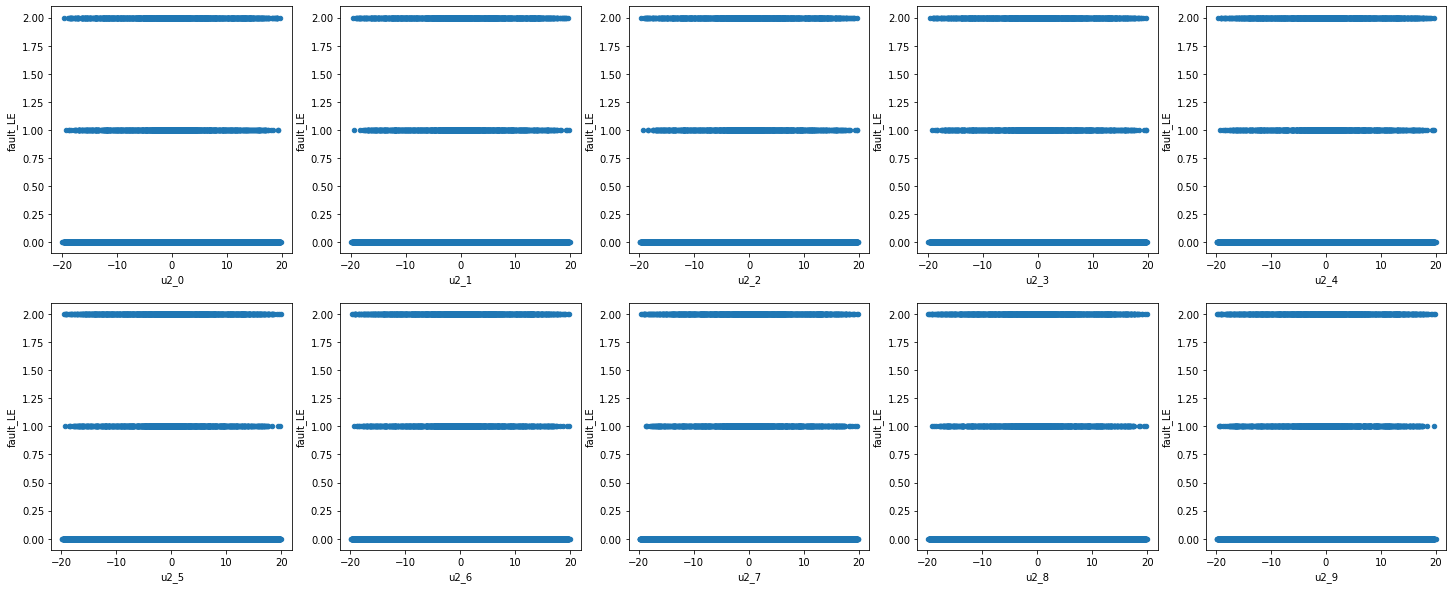

In [205]:
plot_on_key(df, 'u2')

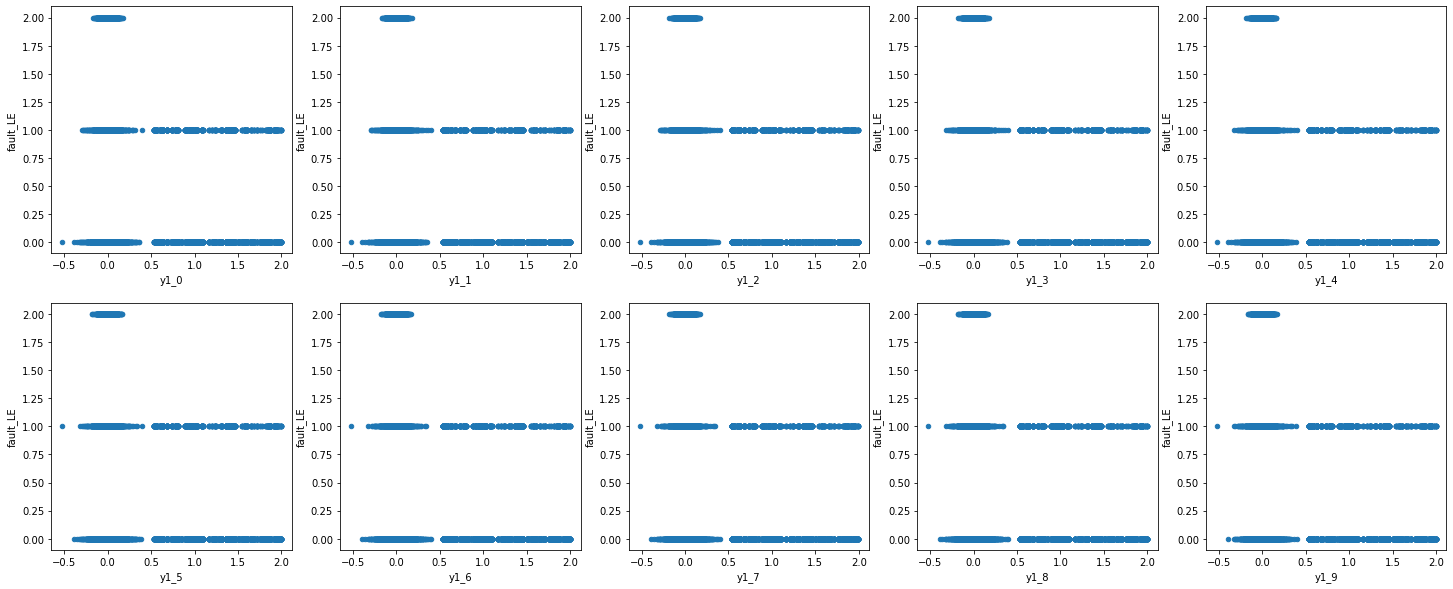

In [206]:
plot_on_key(df, 'y1')

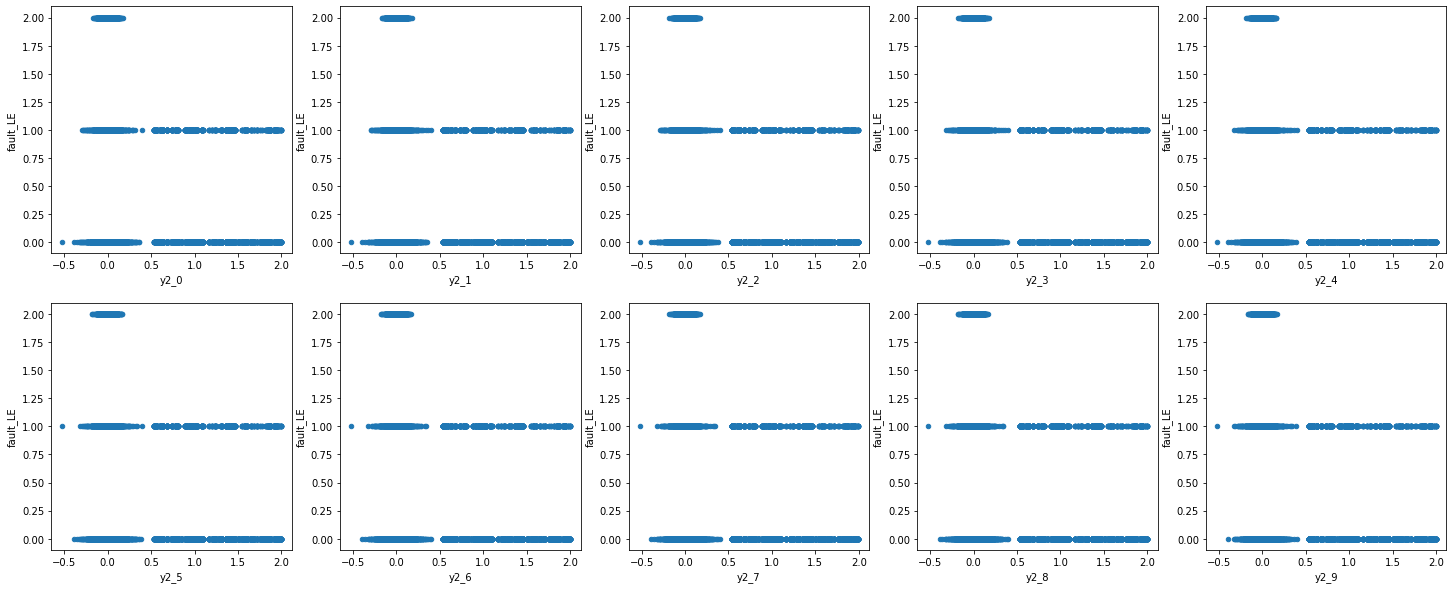

In [207]:
plot_on_key(df, 'y2')

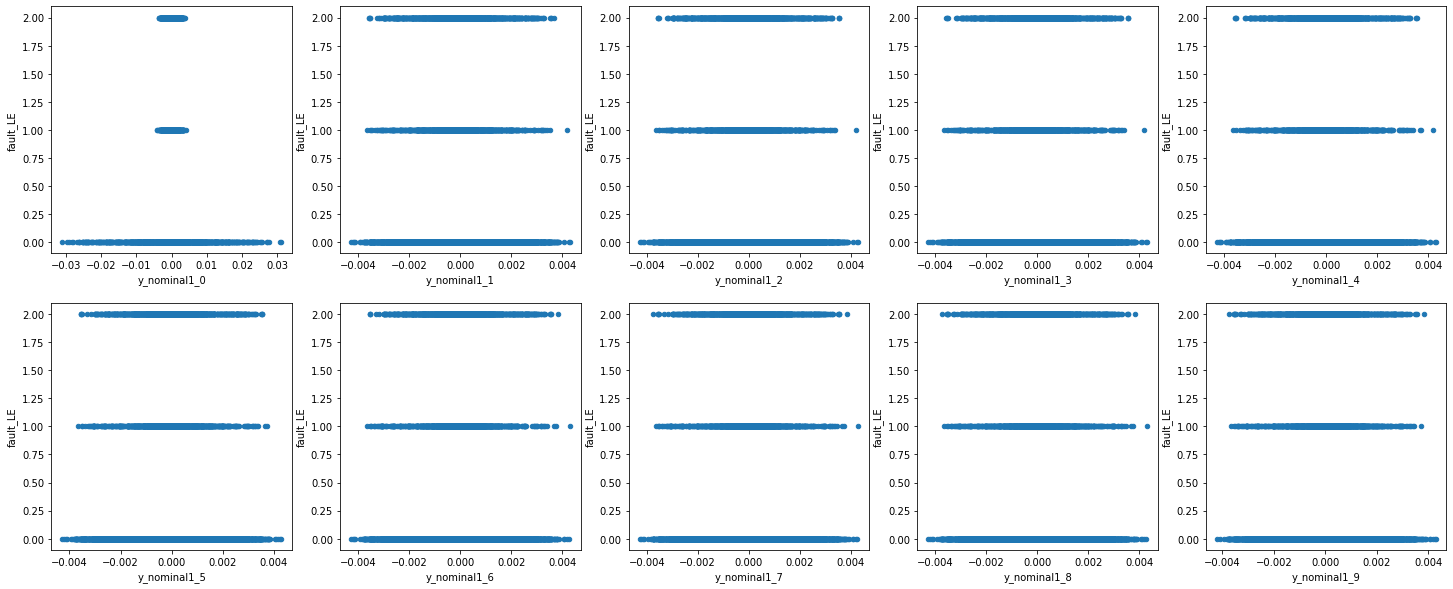

In [208]:
plot_on_key(df, 'y_nominal1')

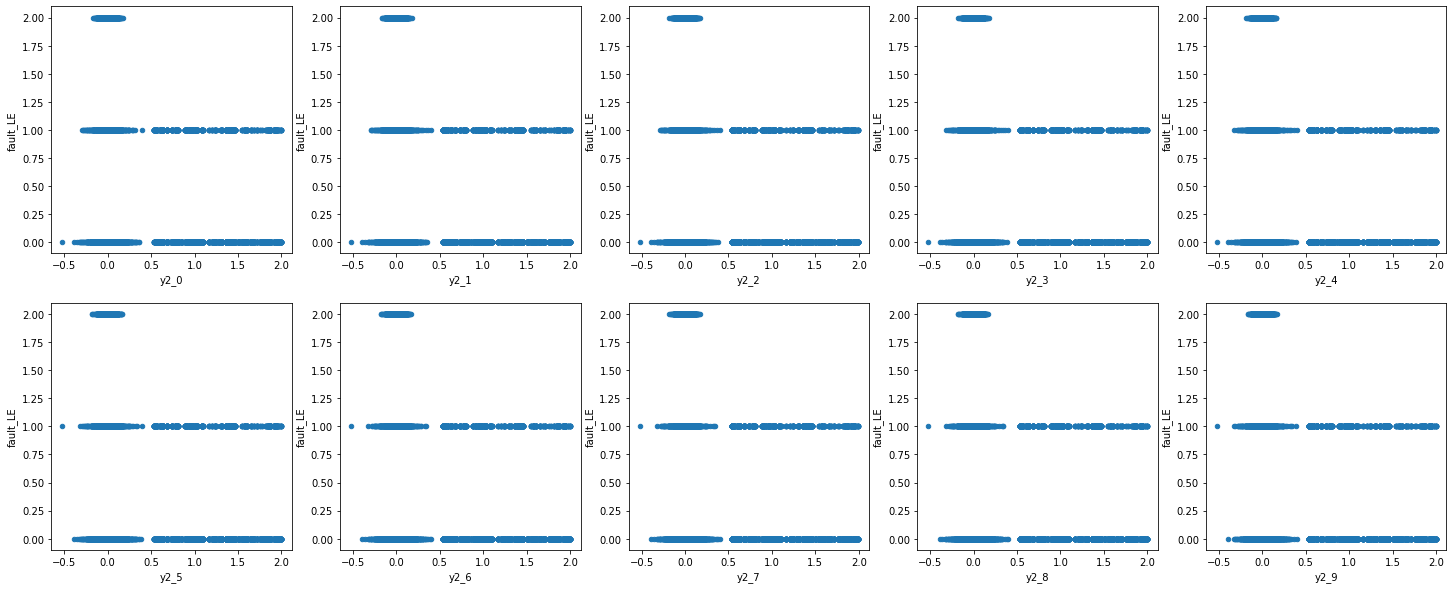

In [209]:
plot_on_key(df, 'y2')

Явных зависимостей не обнаружено

Просмотрим распределение признаков

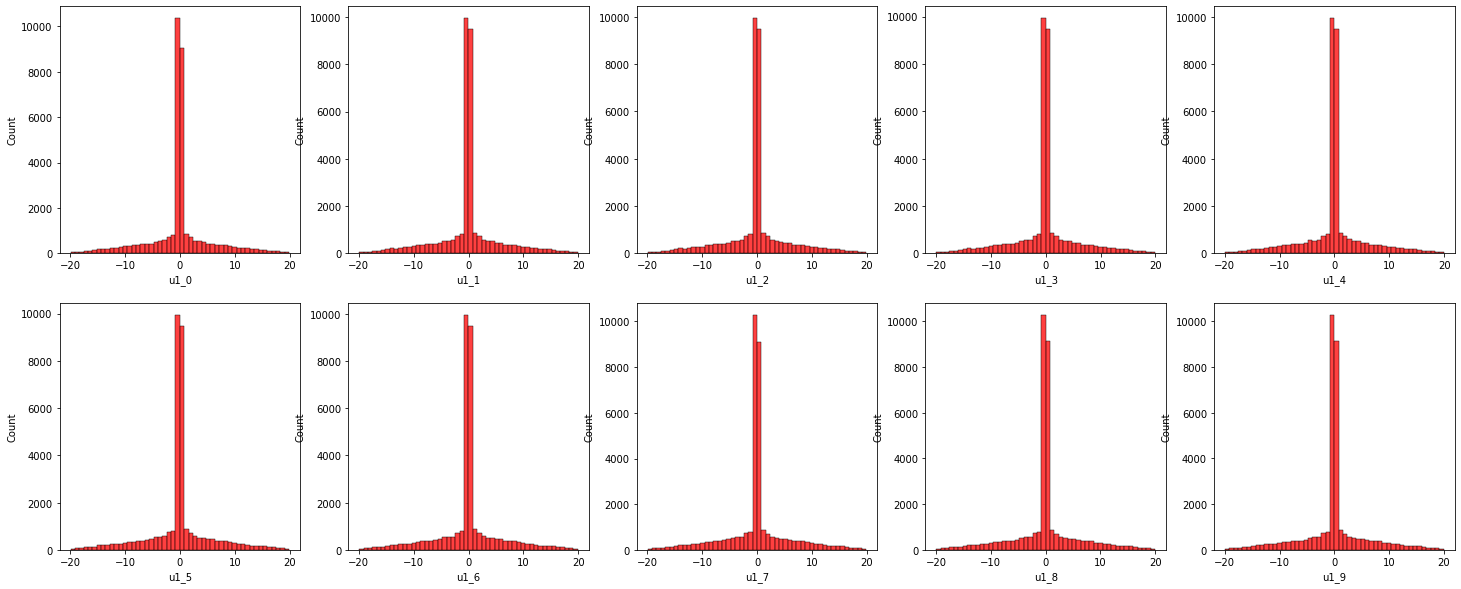

In [210]:
def distplot_on_key(df, key):
    cols = [col for col in df.columns if key in col and 'fault' not in col][:10]
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
    for idx, feature in enumerate(cols):
        sns.histplot(df[feature], bins=50, color='r', ax=axes[idx // 5, idx % 5])
    plt.show()
distplot_on_key(df, 'u1')

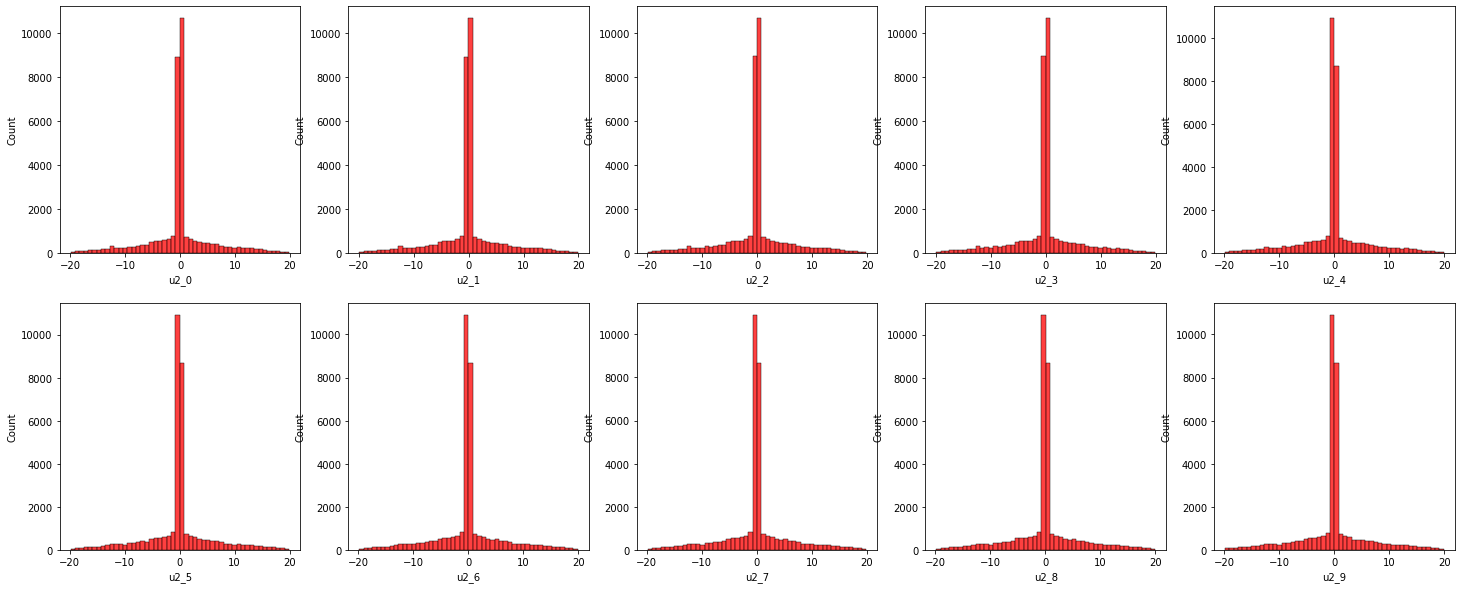

In [211]:
distplot_on_key(df, 'u2')

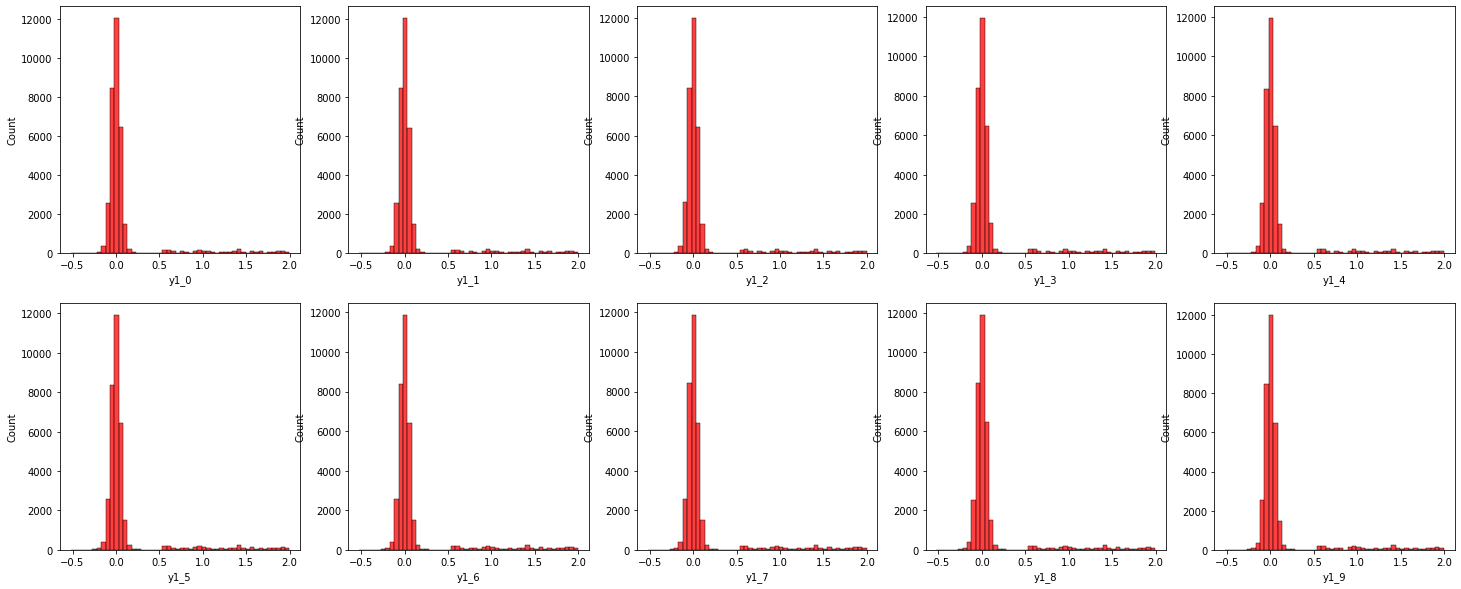

In [212]:
distplot_on_key(df, 'y1')

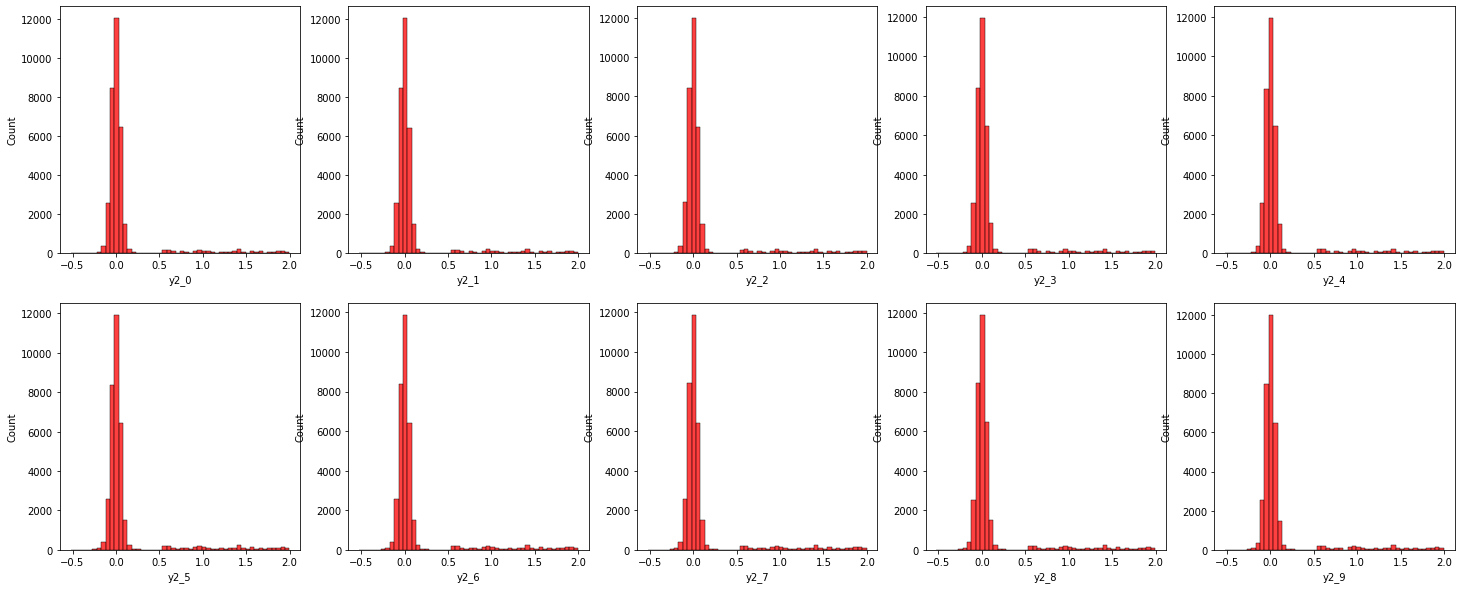

In [213]:
distplot_on_key(df, 'y2')

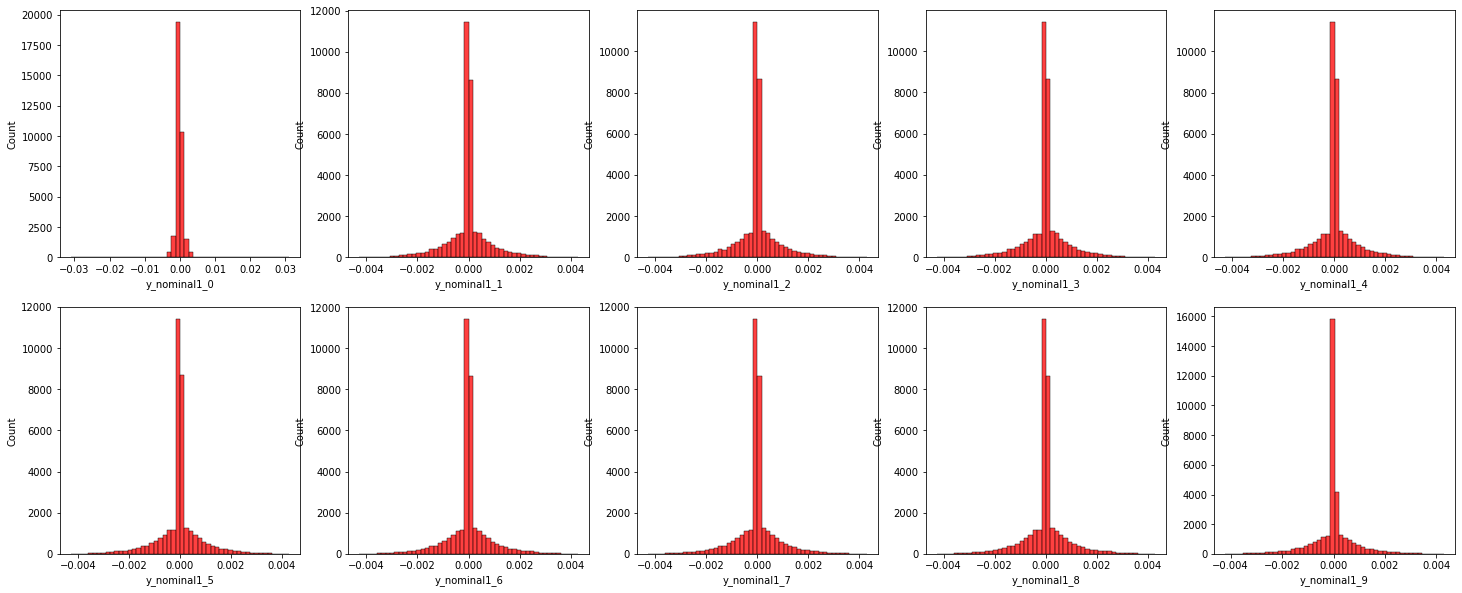

In [214]:
distplot_on_key(df, 'y_nominal1')

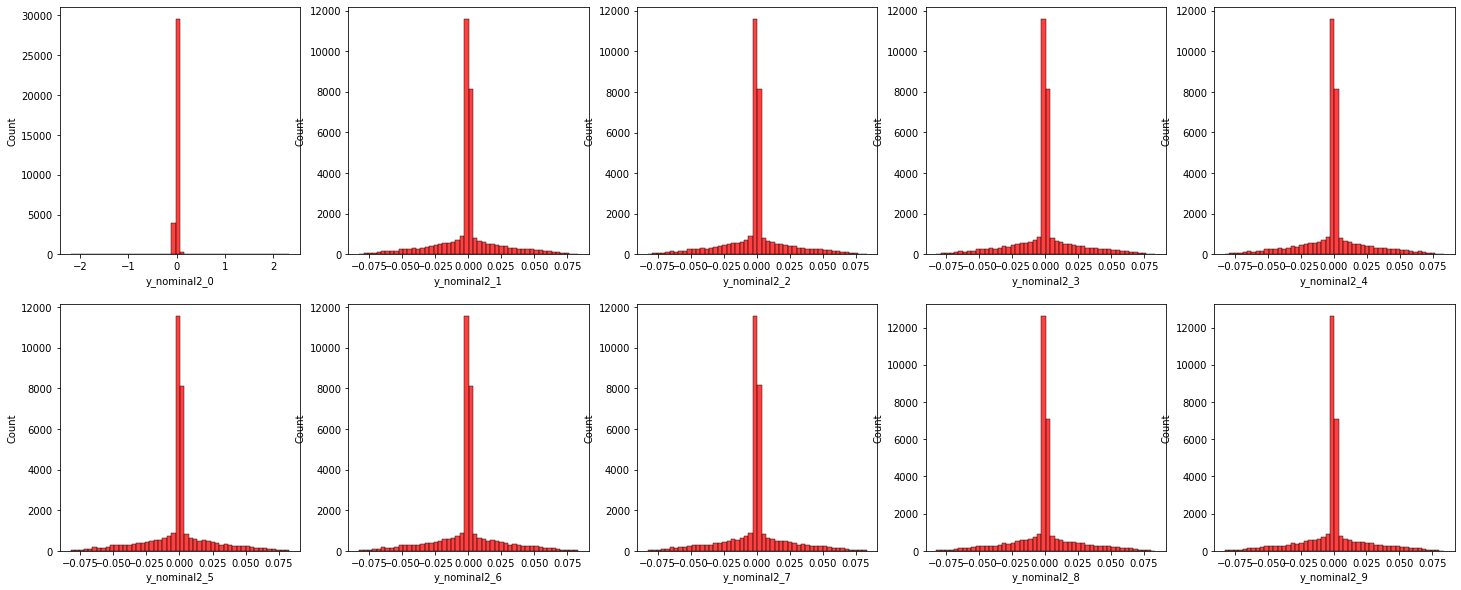

In [215]:
distplot_on_key(df, 'y_nominal2')

Распределение всех признаков близко к нормальному

Проверим корреляцию признаков

<AxesSubplot:>

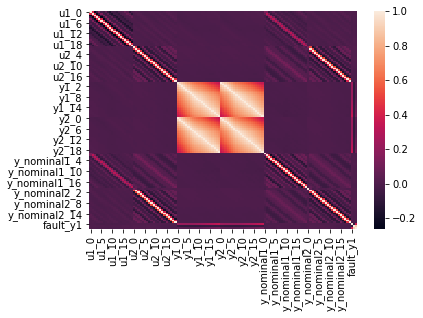

In [216]:
sns.heatmap(df.corr())

Есть существенно скоррелированые признаки, что объясняется невысокой динамикой объекта

Попробуем понизить размерность

In [217]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))

In [ ]:
model = PCA(n_components=3)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

In [ ]:
df_to_draw = pd.DataFrame({
    'class': df['fault_LE'],
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
    'pca3': pca_coords[:, 2],
})
colors = ['r', 'g', 'b']

In [ ]:
df_to_draw.shape

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

for k, f in enumerate(df_to_draw.iterrows()):
    if k % 100 == 0:
        ax.scatter(f[1]['pca1'], f[1]['pca2'], f[1]['pca3'], c=colors[int(f[1]['class'])])
    if k % 1000 == 0:
        print(k)
plt.show()

Разделимость плоскостью не наблюдается

## Feature engineering

Исходя из поставленной задачи, заменим измеренные и ожидаемые значения на их разницу

In [260]:
df_fe = df.copy()

In [261]:
y_cols = [col for col in df_fe.columns if 'y1' in col and 'fault' not in col]
y_nominal_cols = [col for col in df_fe.columns if 'y_nominal1' in col and 'fault' not in col]
for i in range(len(y_cols)):
    df_fe['dev_y1_'+ y_cols[i].split('_')[-1]] = df_fe[y_cols[i]] - df_fe[y_nominal_cols[i]]
    df_fe.drop([y_cols[i], y_nominal_cols[i]], axis=1, inplace=True)
    
y_cols = [col for col in df.columns if 'y2' in col and 'fault' not in col]
y_nominal_cols = [col for col in df.columns if 'y_nominal2' in col and 'fault' not in col]
for i in range(len(y_cols)):
    df_fe['dev_y2_'+ y_cols[i].split('_')[-1]] = df_fe[y_cols[i]] - df_fe[y_nominal_cols[i]]
    df_fe.drop([y_cols[i], y_nominal_cols[i]], axis=1, inplace=True)

In [262]:
df_fe.columns

Index(['u1_0', 'u1_1', 'u1_2', 'u1_3', 'u1_4', 'u1_5', 'u1_6', 'u1_7', 'u1_8',
       'u1_9', 'u1_10', 'u1_11', 'u1_12', 'u1_13', 'u1_14', 'u1_15', 'u1_16',
       'u1_17', 'u1_18', 'u1_19', 'u2_0', 'u2_1', 'u2_2', 'u2_3', 'u2_4',
       'u2_5', 'u2_6', 'u2_7', 'u2_8', 'u2_9', 'u2_10', 'u2_11', 'u2_12',
       'u2_13', 'u2_14', 'u2_15', 'u2_16', 'u2_17', 'u2_18', 'u2_19',
       'fault_y1', 'fault_y2', 'fault_LE', 'dev_y1_0', 'dev_y1_1', 'dev_y1_2',
       'dev_y1_3', 'dev_y1_4', 'dev_y1_5', 'dev_y1_6', 'dev_y1_7', 'dev_y1_8',
       'dev_y1_9', 'dev_y1_10', 'dev_y1_11', 'dev_y1_12', 'dev_y1_13',
       'dev_y1_14', 'dev_y1_15', 'dev_y1_16', 'dev_y1_17', 'dev_y1_18',
       'dev_y1_19', 'dev_y2_0', 'dev_y2_1', 'dev_y2_2', 'dev_y2_3', 'dev_y2_4',
       'dev_y2_5', 'dev_y2_6', 'dev_y2_7', 'dev_y2_8', 'dev_y2_9', 'dev_y2_10',
       'dev_y2_11', 'dev_y2_12', 'dev_y2_13', 'dev_y2_14', 'dev_y2_15',
       'dev_y2_16', 'dev_y2_17', 'dev_y2_18', 'dev_y2_19'],
      dtype='object')

Добавим скользящие средние c окном 10

In [263]:
cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col or
                                      'u1' in col or
                                      'u2' in col) and 'fault' not in col]
for col in cols:
    df_fe['roll_' + col] = df_fe[col].rolling(10).mean()

In [264]:
df_fe.shape

(34720, 163)

In [265]:
df_fe.head()

,u1_0,u1_1,u1_2,u1_3,u1_4,u1_5,u1_6,u1_7,u1_8,u1_9,...,roll_dev_y2_10,roll_dev_y2_11,roll_dev_y2_12,roll_dev_y2_13,roll_dev_y2_14,roll_dev_y2_15,roll_dev_y2_16,roll_dev_y2_17,roll_dev_y2_18,roll_dev_y2_19
0,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,0.207286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
df_fe[[col for col in df_fe.columns if 'roll' in col]].describe()

,roll_u1_0,roll_u1_1,roll_u1_2,roll_u1_3,roll_u1_4,roll_u1_5,roll_u1_6,roll_u1_7,roll_u1_8,roll_u1_9,...,roll_dev_y2_10,roll_dev_y2_11,roll_dev_y2_12,roll_dev_y2_13,roll_dev_y2_14,roll_dev_y2_15,roll_dev_y2_16,roll_dev_y2_17,roll_dev_y2_18,roll_dev_y2_19
count,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,...,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000
mean,-0.032646,-0.036791,-0.022393,-0.023023,-0.038091,-0.036617,-0.026381,-0.023925,-0.024037,-0.028867,...,0.093757,0.088932,0.084253,0.079645,0.075045,0.070333,0.066018,0.061791,0.057649,0.053604
std,2.073253,2.064237,2.065041,2.058460,2.044385,2.029154,2.022630,2.032779,2.047096,2.059367,...,0.317893,0.309625,0.300745,0.291780,0.282705,0.273100,0.263301,0.253335,0.243390,0.233505
min,-15.348078,-15.348078,-15.348078,-15.348078,-15.348078,-15.348078,-15.348078,-15.348078,-15.348078,-15.348078,...,-0.119262,-0.119262,-0.119262,-0.119262,-0.119262,-0.119262,-0.119262,-0.119262,-0.119262,-0.119262
25%,-0.334985,-0.341258,-0.332915,-0.332915,-0.340193,-0.338281,-0.332859,-0.332859,-0.335433,-0.338695,...,-0.010885,-0.010907,-0.011086,-0.011082,-0.011173,-0.011352,-0.011216,-0.011039,-0.010865,-0.010810
50%,-0.014036,-0.015822,-0.012244,-0.012369,-0.015934,-0.014905,-0.010996,-0.011698,-0.011683,-0.014905,...,0.002929,0.002747,0.002694,0.002540,0.002293,0.001946,0.001993,0.002039,0.002041,0.002019
75%,0.296923,0.294101,0.300446,0.303748,0.295509,0.296285,0.303748,0.304766,0.303447,0.297105,...,0.019356,0.018699,0.018315,0.018023,0.017562,0.016955,0.016802,0.016472,0.016125,0.015936
max,15.428916,15.428916,15.428916,15.547926,15.428916,15.428916,15.023512,14.738247,14.364710,14.069501,...,2.001296,2.001296,2.001296,2.001296,2.001296,2.001296,2.001296,2.001296,2.001296,2.001296


<AxesSubplot:>

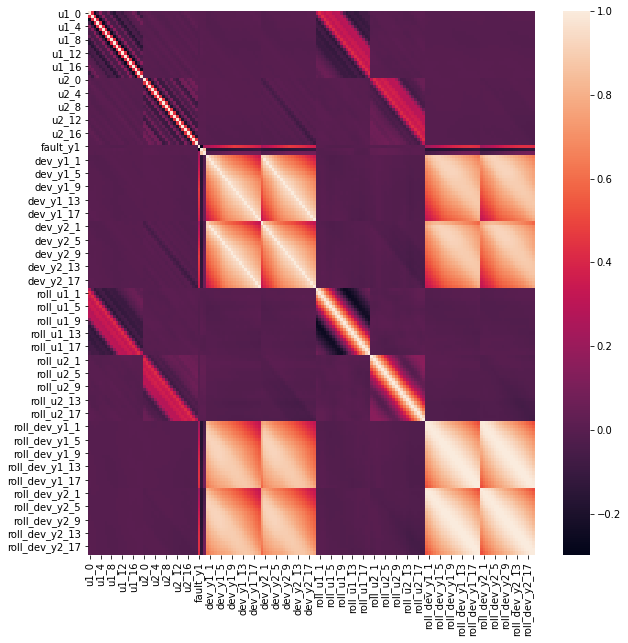

In [267]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_fe.corr())

Добавим первые производные

In [268]:
cols = [col for col in df_fe.columns if ('y1' in col or
                                      'y2' in col) and
        ('fault' not in col and 'roll' not in col)]
for col in cols:
    for i in range(1, 20):
        df_fe.loc[i, 'V_' + col] = df_fe.loc[i, col] - df_fe.loc[i-1, col]
df_fe.fillna(0, inplace=True)
df_fe.shape

(34720, 203)

In [269]:
df_fe[[col for col in df_fe.columns if 'V_' in col]].describe()

,V_dev_y1_0,V_dev_y1_1,V_dev_y1_2,V_dev_y1_3,V_dev_y1_4,V_dev_y1_5,V_dev_y1_6,V_dev_y1_7,V_dev_y1_8,V_dev_y1_9,...,V_dev_y2_10,V_dev_y2_11,V_dev_y2_12,V_dev_y2_13,V_dev_y2_14,V_dev_y2_15,V_dev_y2_16,V_dev_y2_17,V_dev_y2_18,V_dev_y2_19
count,34720.000000,3.472000e+04,34720.000000,34720.000000,34720.000000,34720.000000,3.472000e+04,34720.000000,34720.000000,34720.000000,...,34720.000000,34720.000000,34720.000000,34720.000000,3.472000e+04,34720.000000,34720.000000,34720.000000,34720.000000,34720.000000
mean,0.000003,-4.756078e-07,0.000002,0.000001,0.000004,0.000001,-5.182700e-07,0.000003,-0.000002,-0.000002,...,-0.000002,0.000002,-0.000003,0.000001,-3.912384e-08,0.000002,0.000002,-0.000002,0.000001,-0.000002
std,0.001558,1.568115e-03,0.001622,0.001657,0.001601,0.001487,1.481396e-03,0.001478,0.001613,0.001607,...,0.001601,0.001545,0.001517,0.001755,1.761417e-03,0.001709,0.001713,0.001654,0.001552,0.001468
min,-0.106776,-1.067759e-01,-0.106776,-0.106776,-0.106776,-0.106776,-1.067759e-01,-0.106776,-0.122358,-0.122358,...,-0.122358,-0.122358,-0.122358,-0.122358,-1.223584e-01,-0.122358,-0.122358,-0.122358,-0.122358,-0.122358
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.114126,1.141259e-01,0.114126,0.114126,0.114126,0.098045,9.804504e-02,0.098045,0.098045,0.098045,...,0.098045,0.098045,0.096809,0.165760,1.657596e-01,0.165760,0.165760,0.165760,0.165760,0.165760


In [270]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34720 entries, 0 to 34719
Columns: 203 entries, u1_0 to V_dev_y2_19
dtypes: float64(202), int64(1)
memory usage: 55.0 MB


<AxesSubplot:>

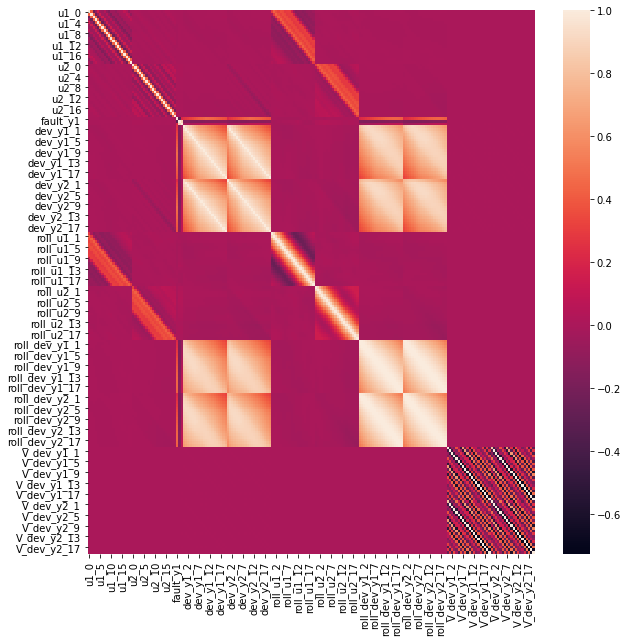

In [271]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_fe.corr())

Добавим вторую производную

In [272]:
cols = [col for col in df_fe.columns if ('V_dev_y1' in col or
                                      'V_dev_y2' in col) 
        and ('fault' not in col and 'roll' not in col)]
for col in cols:
    for i in range(1, 20):
        df_fe.loc[i, 'A_' + col] = df_fe.loc[i, col] - df_fe.loc[i-1, col]
df_fe.fillna(0, inplace=True)
df_fe.shape

(34720, 243)

In [273]:
df_fe[[col for col in df_fe.columns if 'A_' in col]].describe()

,A_V_dev_y1_0,A_V_dev_y1_1,A_V_dev_y1_2,A_V_dev_y1_3,A_V_dev_y1_4,A_V_dev_y1_5,A_V_dev_y1_6,A_V_dev_y1_7,A_V_dev_y1_8,A_V_dev_y1_9,...,A_V_dev_y2_10,A_V_dev_y2_11,A_V_dev_y2_12,A_V_dev_y2_13,A_V_dev_y2_14,A_V_dev_y2_15,A_V_dev_y2_16,A_V_dev_y2_17,A_V_dev_y2_18,A_V_dev_y2_19
count,34720.000000,34720.000000,34720.000000,34720.000000,3.472000e+04,3.472000e+04,3.472000e+04,34720.000000,34720.000000,3.472000e+04,...,3.472000e+04,34720.000000,34720.000000,34720.000000,3.472000e+04,3.472000e+04,3.472000e+04,34720.000000,3.472000e+04,3.472000e+04
mean,0.000003,-0.000002,0.000002,-0.000002,4.146821e-07,8.261059e-07,-8.526373e-07,0.000001,-0.000004,5.682568e-07,...,-4.578612e-07,0.000001,-0.000002,0.000005,-9.272205e-07,2.060348e-08,-5.913416e-07,-0.000001,2.592615e-07,-6.668994e-07
std,0.002532,0.002632,0.002740,0.002869,2.743881e-03,2.653175e-03,2.632365e-03,0.002623,0.002785,2.867586e-03,...,2.892317e-03,0.002737,0.002741,0.003044,3.209206e-03,3.155934e-03,3.159576e-03,0.002989,2.784042e-03,2.626833e-03
min,-0.199212,-0.199212,-0.199212,-0.199212,-1.992123e-01,-1.992123e-01,-1.992123e-01,-0.199212,-0.199212,-1.992123e-01,...,-1.992123e-01,-0.199212,-0.199212,-0.199212,-1.992123e-01,-1.992123e-01,-1.992123e-01,-0.197953,-1.979527e-01,-1.979527e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
max,0.203585,0.203585,0.203585,0.203585,2.035849e-01,2.035849e-01,2.035849e-01,0.203585,0.203585,2.035849e-01,...,2.035849e-01,0.203585,0.203585,0.247042,2.470424e-01,2.470424e-01,2.470424e-01,0.247042,2.470424e-01,2.470424e-01


In [274]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34720 entries, 0 to 34719
Columns: 243 entries, u1_0 to A_V_dev_y2_19
dtypes: float64(242), int64(1)
memory usage: 65.6 MB


In [275]:
df_fe.to_csv('dataset_with_features.csv')

<AxesSubplot:>

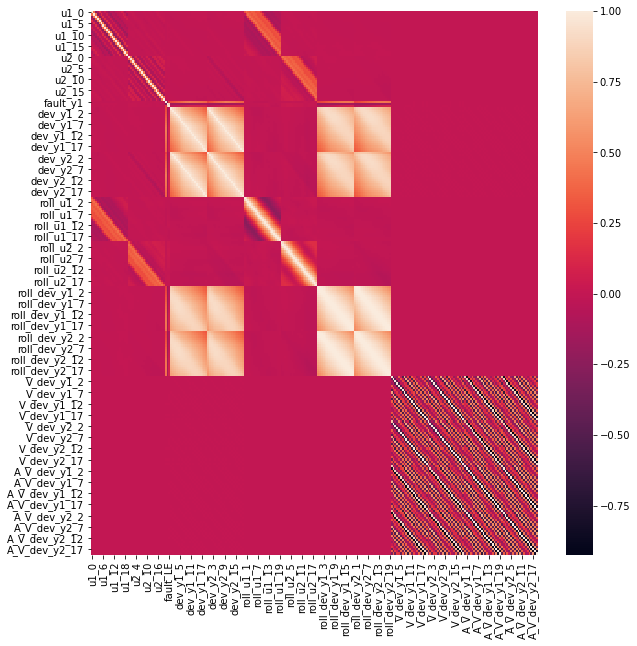

In [276]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_fe.corr())

Сгенерированные признаки имеют низкую корреляцию

Преобразуем данные в два формата:
- однострочный массив с label encoding для случайного леса и градиентного бустинга
- временные серии и binary encoding для реккурентных и сверточных нейросетей
и нормализуем

In [277]:
df_fe = pd.read_csv('dataset_with_features.csv', index_col=0)

In [278]:
[col for col in df_fe.columns if 'fault' in col]

['fault_y1', 'fault_y2', 'fault_LE']

In [279]:
scaler = StandardScaler()
X_array = scaler.fit_transform(df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1))

In [280]:
y_le = np.array(df_fe['fault_LE'])
X_array.shape, y_le.shape

((34720, 240), (34720,))

In [281]:
X_series = X_array.reshape((X_array.shape[0], 20, 12))
y_ohe = np.array(df_fe[['fault_y1', 'fault_y2']])
X_series.shape, y_ohe.shape

((34720, 20, 12), (34720, 2))

## Baseline
EDA не показал явной разделимости классов. Поэтому рассмотрим более "тяжелые" методы

Проведем стратифицированное разделение данных на обучающие, валидационные и тестовые

In [282]:
X_array_train, X_array_test, y_le_train, y_le_test = train_test_split(X_array, y_le, stratify=y_le, test_size=0.25, random_state=0)
X_array_train, X_array_val, y_le_train, y_le_val = train_test_split(X_array_train, y_le_train, stratify=y_le_train, test_size=0.25, random_state=0)

In [283]:
X_series_train, X_series_test, y_ohe_train, y_ohe_test = train_test_split(X_series, y_ohe, stratify=y_ohe, test_size=0.25)
X_series_train, X_series_val, y_ohe_train, y_ohe_val = train_test_split(X_series_train, y_ohe_train, stratify=y_ohe_train, test_size=0.25)

Для задачи классификации оценим метрику для простейшего классификатора по наиболее часто встречающемуся ответу

In [284]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_array_train, y_le_train)

DummyClassifier(strategy='most_frequent')

In [285]:
predictions = dummy_clf.predict(X_array_val)
print('Dummy f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

Dummy f1-score:  0.23383531132608623
[[3517    0    0]
 [1486    0    0]
 [1507    0    0]]


### Градиентный бустинг

In [287]:
gbm_clf = GradientBoostingClassifier()
gbm_clf.fit(X_array_train, y_le_train)
predictions = gbm_clf.predict(X_array_val)
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.5811858737177831
[[3367   47  103]
 [ 534  896   56]
 [1282    5  220]]


### LightGBM

In [288]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {'learning_rate': (0.01, 0.1, 0.4, 0.8, 1),
              'max_leaf_nodes': (10, 20, 30, 40),
              'max_depth':(1, 2, 4)}

lgbm_clf = GridSearchCV(HistGradientBoostingClassifier(), param_grid, refit=True, cv=5, verbose=2)
lgbm_clf.fit(X_array_train, y_le_train)
lgbm_clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   1.8s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   1.9s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=10; total time=   1.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   1.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   1.8s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=20; total time=   1.6s
[CV] END .learning_rate=0.01, max_depth=1, max_leaf_nodes=30; total time=   1.6s
[CV] END .learning_rate=0.01, max_depth=1, max_

{'learning_rate': 0.4, 'max_depth': 4, 'max_leaf_nodes': 30}

In [293]:
predictions = lgbm_clf.predict(X_array_val)
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.7521079827002909
[[3121   83  313]
 [ 215 1208   63]
 [ 735   21  751]]


### Random forrest

In [290]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'min_samples_split': (2, 4, 6, 8),
              'min_samples_leaf': (1, 2, 4)}

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, refit=True, verbose=2)
rf_clf.fit(X_array_train, y_le_train)
rf_clf.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  15.5s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  16.1s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  16.1s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  15.7s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  15.8s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  16.0s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  16.1s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  16.4s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  15.3s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  15.6s
[CV] END ............min_samples_leaf=1, min_samples_split=6; total time=  15.4s
[CV] END ............min_samples_leaf=1, min_sam

{'min_samples_leaf': 1, 'min_samples_split': 2}

In [291]:
n_estimators_values = (100, 200, 300, 400, 500, 600)

train_score, test_score = [], []
for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=4, n_estimators=n_estimators, random_state=0)
    rf_clf.fit(X_array_train, y_le_train)
    predictions = rf_clf.predict(X_array_train)
    train_f1 = f1_score(y_le_train, predictions, average='weighted')
    train_score.append(train_f1)
    predictions = rf_clf.predict(X_array_val)
    test_f1 = f1_score(y_le_val, predictions, average='weighted')
    test_score.append(test_f1)

In [292]:
temp_df =  pd.DataFrame({'n_estimators': n_estimators_values,
                         'train_f1': train_score,
                         'val_f1': test_score})
px.line(temp_df, x='n_estimators', y=['train_f1', 'val_f1'])

In [295]:
depth_values = ( 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44)

train_score, test_score = [], []
for depth in depth_values:
    rf_clf = RandomForestClassifier(max_depth=depth, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=0)
    rf_clf.fit(X_array_train, y_le_train)
    predictions = rf_clf.predict(X_array_train)
    train_f1 = f1_score(y_le_train, predictions, average='weighted')
    train_score.append(train_f1)
    predictions = rf_clf.predict(X_array_val)
    test_f1 = f1_score(y_le_val, predictions, average='weighted')
    test_score.append(test_f1)

In [296]:
temp_df =  pd.DataFrame({'depth': depth_values,
                         'train_f1': train_score,
                         'val_f1': test_score})
px.line(temp_df, x='depth', y=['train_f1', 'val_f1'])

In [297]:
rf_clf = RandomForestClassifier(max_depth= 35,  min_samples_leaf=1, min_samples_split=4, n_estimators=200, random_state=0)
rf_clf.fit(X_array_train, y_le_train)
predictions = rf_clf.predict(X_array_val)
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.7609646944202128
[[3437   33   47]
 [ 393 1073   20]
 [ 807    4  696]]


### XGBoost

In [298]:
estimator = XGBClassifier(
    objective= 'multi:softmax',
    nthread=4,
    seed=42
)

In [299]:
parameters = {
    'max_depth': range (10, 51, 10),
    'n_estimators': [20, 40, 60],
    'learning_rate': [0.1]
}

In [300]:
xgb_clf = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 8,
    cv = 5,
    verbose = 2
)

In [301]:
xgb_clf.fit(X_array_train, y_le_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[11:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None,
                                     random_state=None, reg_alpha=N

In [302]:
predictions = xgb_clf.predict(X_array_val)
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.6185680215514707
[[3412   30   75]
 [ 539  880   67]
 [1169    8  330]]


### Нейронная сеть

In [303]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical

In [304]:
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy',])

In [305]:
history = model.fit(X_array_train, y_ohe_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_array_val, y_ohe_val))

Epoch 1/100
611/611 - 4s - loss: 3053837824.0000 - categorical_accuracy: 0.5044 - val_loss: 449813888.0000 - val_categorical_accuracy: 0.7685 - 4s/epoch - 6ms/step
Epoch 2/100
611/611 - 2s - loss: 490019979264.0000 - categorical_accuracy: 0.5034 - val_loss: 366555037696.0000 - val_categorical_accuracy: 0.2315 - 2s/epoch - 3ms/step
Epoch 3/100
611/611 - 2s - loss: 4100721737728.0000 - categorical_accuracy: 0.4963 - val_loss: 2110224990208.0000 - val_categorical_accuracy: 0.2315 - 2s/epoch - 3ms/step
Epoch 4/100
611/611 - 2s - loss: 3539376537600.0000 - categorical_accuracy: 0.5030 - val_loss: 3104108183552.0000 - val_categorical_accuracy: 0.2315 - 2s/epoch - 3ms/step
Epoch 5/100
611/611 - 2s - loss: 3439322202112.0000 - categorical_accuracy: 0.4972 - val_loss: 9359024193536.0000 - val_categorical_accuracy: 0.2315 - 2s/epoch - 3ms/step
Epoch 6/100
611/611 - 2s - loss: 7193065684992.0000 - categorical_accuracy: 0.4991 - val_loss: 9298498289664.0000 - val_categorical_accuracy: 0.2315 - 2s/

In [306]:
predictions_prob = model.predict(X_array_val)
predictions = predictions_prob.argmax(axis=-1)

204/204 [==============================] - 0s 1ms/step


In [307]:
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.23383531132608623
[[3517    0    0]
 [1486    0    0]
 [1507    0    0]]


### LSTM

In [308]:
from keras.layers import LSTM

In [314]:
model = Sequential()
model.add(LSTM(64, input_shape = X_series[0].shape, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, input_shape = X_series[0].shape))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', metrics=['categorical_crossentropy'], optimizer="adam")

In [315]:
model.fit(X_series_train, y_ohe_train, batch_size=64, epochs=200, verbose=2, validation_data=(X_series_val, y_ohe_val))

Epoch 1/200


306/306 - 12s - loss: 0.5009 - categorical_crossentropy: 0.2723 - val_loss: 0.4721 - val_categorical_crossentropy: 0.2591 - 12s/epoch - 38ms/step
Epoch 2/200
306/306 - 7s - loss: 0.4783 - categorical_crossentropy: 0.2657 - val_loss: 0.4640 - val_categorical_crossentropy: 0.2563 - 7s/epoch - 24ms/step
Epoch 3/200
306/306 - 7s - loss: 0.4699 - categorical_crossentropy: 0.2616 - val_loss: 0.4588 - val_categorical_crossentropy: 0.2500 - 7s/epoch - 23ms/step
Epoch 4/200
306/306 - 7s - loss: 0.4603 - categorical_crossentropy: 0.2507 - val_loss: 0.4442 - val_categorical_crossentropy: 0.2416 - 7s/epoch - 24ms/step
Epoch 5/200
306/306 - 7s - loss: 0.4503 - categorical_crossentropy: 0.2418 - val_loss: 0.4478 - val_categorical_crossentropy: 0.2338 - 7s/epoch - 24ms/step
Epoch 6/200
306/306 - 7s - loss: 0.4423 - categorical_crossentropy: 0.2350 - val_loss: 0.4445 - val_categorical_crossentropy: 0.2334 - 7s/epoch - 24ms/step
Epoch 7/200
306/306 - 7s - loss: 0.4381 - categorical_crossentropy: 0.2321

In [316]:
predictions_prob = model.predict(X_series_val)
predictions = predictions_prob.argmax(axis=-1)

204/204 [==============================] - 2s 5ms/step


In [317]:
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.24361779016556892
[[1057 2460    0]
 [ 446 1040    0]
 [ 437 1070    0]]


### Сверточная нейронная сеть

In [320]:
from keras.layers import MaxPooling1D, Flatten, Conv1D

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(20, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy',])

In [321]:
history = model.fit(X_series_train, y_ohe_train, epochs=100, verbose=2, validation_data=(X_series_val, y_ohe_val))

Epoch 1/100


611/611 - 3s - loss: 1.5667 - binary_accuracy: 0.7879 - val_loss: 1.4576 - val_binary_accuracy: 0.8015 - 3s/epoch - 4ms/step
Epoch 2/100
611/611 - 2s - loss: 1.4434 - binary_accuracy: 0.7950 - val_loss: 0.6110 - val_binary_accuracy: 0.7525 - 2s/epoch - 3ms/step
Epoch 3/100
611/611 - 2s - loss: 0.5342 - binary_accuracy: 0.7992 - val_loss: 0.4929 - val_binary_accuracy: 0.8063 - 2s/epoch - 3ms/step
Epoch 4/100
611/611 - 2s - loss: 0.4775 - binary_accuracy: 0.8025 - val_loss: 0.4801 - val_binary_accuracy: 0.8074 - 2s/epoch - 3ms/step
Epoch 5/100
611/611 - 2s - loss: 0.4658 - binary_accuracy: 0.8058 - val_loss: 0.4767 - val_binary_accuracy: 0.8073 - 2s/epoch - 3ms/step
Epoch 6/100
611/611 - 2s - loss: 0.4585 - binary_accuracy: 0.8058 - val_loss: 0.4785 - val_binary_accuracy: 0.8081 - 2s/epoch - 3ms/step
Epoch 7/100
611/611 - 2s - loss: 0.4514 - binary_accuracy: 0.8059 - val_loss: 0.4555 - val_binary_accuracy: 0.8104 - 2s/epoch - 3ms/step
Epoch 8/100
611/611 - 2s - loss: 0.4370 - binary_accu

In [322]:
predictions_prob = model.predict(X_series_val)
predictions = predictions_prob.argmax(axis=-1)

204/204 [==============================] - 0s 2ms/step


In [323]:
print('f1-score: ', f1_score(y_le_val, predictions, average='macro'))
print(confusion_matrix(y_le_val, predictions))

f1-score:  0.2694013333622449
[[1485 2032    0]
 [ 611  875    0]
 [ 601  906    0]]


### Итого
Лучший результат показал случайный лес. Его берем за бейзлайн.

In [326]:
rf_clf = RandomForestClassifier(max_depth= 35,  min_samples_leaf=1, min_samples_split=4, n_estimators=200, random_state=0)
rf_clf.fit(X_array_train, y_le_train)
predictions = rf_clf.predict(X_array_test)
print('f1-score: ', f1_score(y_le_test, predictions, average='macro'))
print(confusion_matrix(y_le_test, predictions))

f1-score:  0.7570004494950048
[[4598   40   52]
 [ 548 1414   19]
 [1100    2  907]]


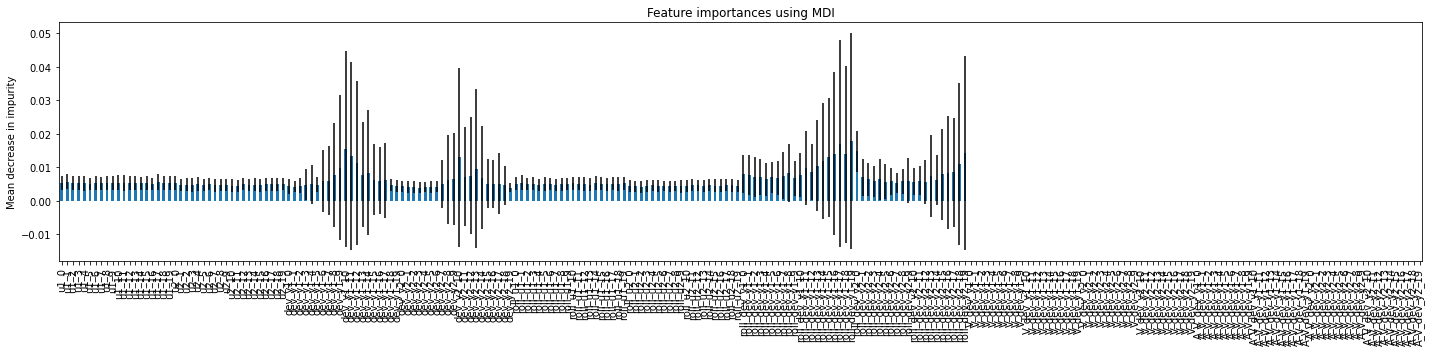

In [327]:
importances = rf_clf.feature_importances_
feature_names = df_fe.drop(['fault_y1', 'fault_y2', 'fault_LE'], axis=1).columns
forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(20, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
